In [368]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, polynomialRegression

In [369]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')

In [370]:
post_type = data['post_type'].iloc[0]
street = data['street'].iloc[0]
ward = data['ward'].iloc[0]
district = data['district'].iloc[0]

In [371]:
print("Data length: ", len(data))

Data length:  255


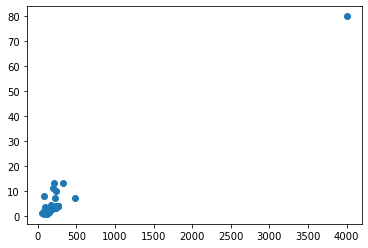

In [372]:
plt.scatter(data['area'], data['price'])
plt.show()

In [373]:
# preprocess data:

# sort data in post_date order to drop old data has same area:
# data = data.sort_values(by=['posted_date'])

# Drop duplicates:    
# data = data.drop_duplicates(subset='area', keep='last', inplace=False)

# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data in area order:
data = data.sort_values(by=['area'])

In [374]:
data

,area,price
0,56.0,1.198400
1,75.0,1.400000
2,80.0,1.221453
3,80.4,7.702320
4,81.0,1.228333
5,84.0,1.300000
6,85.0,1.282500
7,86.0,1.300000
8,87.0,2.450000
9,90.0,1.701429


In [375]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [376]:
print("Data length: ", len(data))

Data length:  37


In [377]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

In [378]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean - price_std) )]

In [379]:
# # remove outliers using box-plot:
# while True:
#     area_minimum, area_maximum = calcMinimumMaximum(data['area'])
#     if (data['area'] > area_minimum).all() and (data['area'] < area_maximum).all():
#         break
#     else:
#         data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# while True:
#     price_minimum, price_maximum = calcMinimumMaximum(data['price'])
#     if (data['price'] > price_minimum).all() and (data['price'] < price_maximum).all():
#         break
#     else:
#         data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [380]:
# area_minimum, area_maximum = calcMinimumMaximum(data['area'])
# data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# price_minimum, price_maximum = calcMinimumMaximum(data['price'])
# data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [381]:
# data = data[(data['area'] > 5.5)]

In [382]:
print("Data length: ", len(data))

Data length:  36


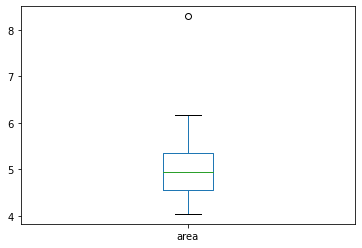

In [383]:
data['area'].plot(kind='box')
plt.show()

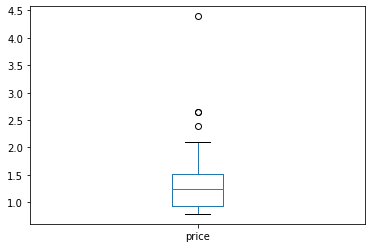

In [384]:
data['price'].plot(kind='box')
plt.show()

In [385]:
print("Data length: ", len(data))

Data length:  36


In [386]:
# data['price'].describe()

In [387]:
# data['area'].describe()

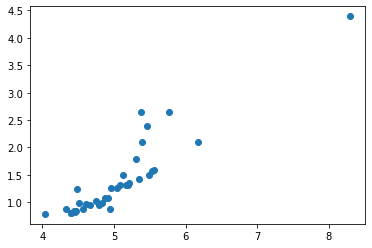

In [388]:
plt.scatter(data['area'], data['price'])
plt.show()

In [389]:
from sklearn.neighbors import NearestNeighbors

# np_area = np.array(data[['area']])
# np_price = np.array(data[['price']])

# data['area'] = np_area
# data['price'] = np_price

# convert dataframe into numpy array:
X = data.to_numpy()

# Apply NN:
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
neighbors.fit(X)

distances, indexes = neighbors.kneighbors(X)

In [390]:
indexes

array([[ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  8,  9, 10,  0],
       [ 2,  3,  4,  5,  6,  1,  9,  8, 10, 11],
       [ 3,  2,  4,  5,  6,  1,  9,  8, 10, 11],
       [ 4,  5,  6,  3,  2,  1,  9,  8, 10, 11],
       [ 5,  6,  4,  3,  2,  9,  1,  8, 10, 11],
       [ 6,  5,  4,  3,  2,  9,  1,  8, 10, 11],
       [ 7,  8, 10, 11, 12,  9,  1,  6,  4,  5],
       [ 8, 10,  9, 11,  6,  4,  5,  1,  3,  2],
       [ 9, 10,  6,  8, 11,  5,  4,  3,  2, 12],
       [10, 11,  9,  8, 12, 13,  6,  5,  4, 14],
       [11, 10, 12,  9, 13,  8, 14,  6,  5, 15],
       [12, 13, 14, 11, 10, 15, 16,  9,  8, 17],
       [13, 14, 12, 11, 15, 17, 16, 10,  9,  8],
       [14, 13, 12, 15, 16, 17, 11, 10,  9, 18],
       [15, 16, 14, 12, 13, 18, 17, 19, 11, 10],
       [16, 15, 14, 13, 12, 18, 19, 17, 20, 11],
       [17, 14, 13, 16, 15, 12, 11, 10,  9, 19],
       [18, 19, 20, 16, 15, 22, 23, 24, 21, 14],
       [19, 20, 18, 22, 23, 24, 16, 15, 21, 14],
       [20, 19, 22, 

In [391]:
distances.mean(axis=1)

array([0.38964668, 0.16488092, 0.13232941, 0.12482336, 0.10402152,
       0.10415962, 0.1034576 , 0.32173859, 0.15680505, 0.13011259,
       0.1422355 , 0.1469992 , 0.14768508, 0.14891774, 0.15297491,
       0.16401451, 0.1708347 , 0.24744424, 0.19382403, 0.16926822,
       0.16159976, 0.22583887, 0.16376278, 0.16962147, 0.17086405,
       0.34548164, 0.20961769, 0.74700285, 0.48169809, 0.58608319,
       0.25236773, 0.28235369, 0.31119304, 0.77118736, 0.77361348,
       3.26360034])

In [392]:
distances.mean()

0.34255720816117474

In [393]:
distances.std()

0.5813507709497412

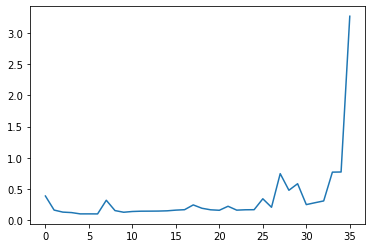

In [394]:
plt.plot(distances.mean(axis=1))

In [395]:
# locate outlier by index:
outlier_indexes = np.where(distances.mean(axis=1) > 0.5)

In [396]:
outlier_values = data.iloc[outlier_indexes]
# outlier_values.index
data = data.drop(outlier_values.index)

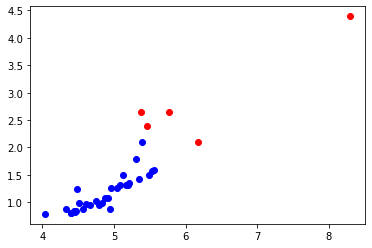

In [397]:
plt.scatter(data['area'], data['price'], color='blue')
plt.scatter(outlier_values['area'], outlier_values['price'], color='red')
plt.show()

In [398]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.3)
test_data, validate_data = train_test_split(test_data, test_size=0.5)

In [399]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  21
Test data length:  5
Validate data length:  5


In [400]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

In [401]:
# scale data:

# Standard Scaler:

# X = StandardScaler().fit_transform(X)
# Y = StandardScaler().fit_transform(Y)

# X_train = StandardScaler().fit_transform(X_train)
# Y_train = StandardScaler().fit_transform(Y_train)

# X_test = StandardScaler().fit_transform(X_test)
# Y_test = StandardScaler().fit_transform(Y_test)

# X_validate = StandardScaler().fit_transform(X_validate)
# Y_validate = StandardScaler().fit_transform(Y_validate)


# Quantile Transformer:

# X = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X)
# Y = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y)

# X_train = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X_train)
# Y_train = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y_train)

# X_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(X_test)
# Y_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(Y_test)

# X_validate = QuantileTransformer(n_quantiles=len(X_validate), output_distribution='uniform').fit_transform(X_validate)
# Y_validate = QuantileTransformer(n_quantiles=len(Y_validate), output_distribution='uniform').fit_transform(Y_validate)

# Power Transformer:

# X = PowerTransformer(method='yeo-johnson').fit_transform(X)
# Y = PowerTransformer(method='yeo-johnson').fit_transform(Y)

# X_train = PowerTransformer(method='yeo-johnson').fit_transform(X_train)
# Y_train = PowerTransformer(method='yeo-johnson').fit_transform(Y_train)

# X_test = PowerTransformer(method='yeo-johnson').fit_transform(X_test)
# Y_test = PowerTransformer(method='yeo-johnson').fit_transform(Y_test)

# X_validate = PowerTransformer(method='yeo-johnson').fit_transform(X_validate)
# Y_validate = PowerTransformer(method='yeo-johnson').fit_transform(Y_validate)

# Log Transformer:

# X = FunctionTransformer(np.log1p).fit_transform(X)
# Y = FunctionTransformer(np.log1p).fit_transform(Y)

# X_train = FunctionTransformer(np.log1p).fit_transform(X_train)
# Y_train = FunctionTransformer(np.log1p).fit_transform(Y_train)

# X_test = FunctionTransformer(np.log1p).fit_transform(X_test)
# Y_test = FunctionTransformer(np.log1p).fit_transform(Y_test)

# X_validate = FunctionTransformer(np.log1p).fit_transform(X_validate)
# Y_validate = FunctionTransformer(np.log1p).fit_transform(Y_validate)

Text(0.5, 1.0, 'Y_validate')

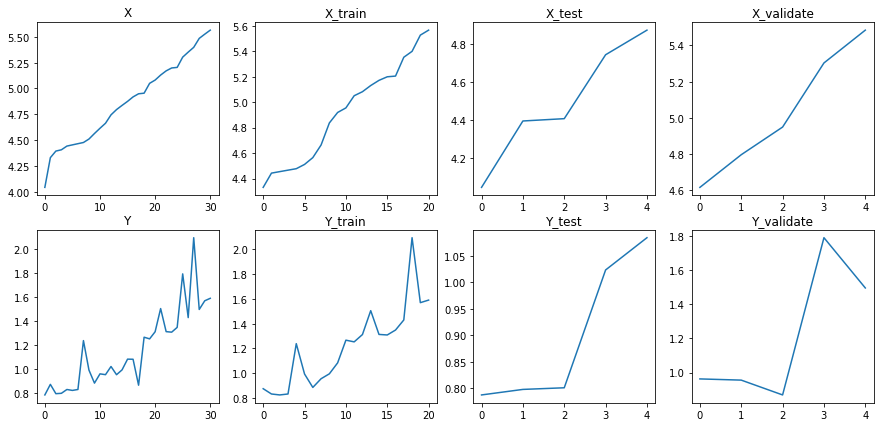

In [402]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

In [403]:
# find model by using linear regression:
linear_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


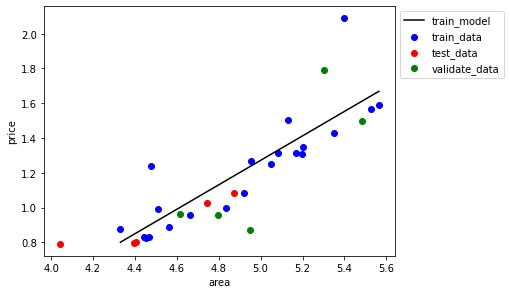

In [404]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [405]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_model.coef_))
print("Linear model intercept: {}".format(linear_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.70361648]]
Linear model intercept: [-2.2464812]
Linear model rmse on train data: 0.16094721227126413
Linear model rmse on test data: 0.10532977292068262





In [406]:
# find model by using polynomial regression:
poly_model, degree, train_rmse, validate_rmse, test_rmse = polynomialRegression(X, Y, X_train, Y_train, X_test, Y_test, X_validate, Y_validate)

# transform X and X_test:
polynomial_features = PolynomialFeatures(degree=degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

# Try predicting Y
Y_train_poly_pred = poly_model.predict(X_train_poly)
Y_test_poly_pred = poly_model.predict(X_test_poly)


Selected Polynomial Regression with degree = 4 and validate RMSE = 0.16872886616386204
Selected Regularized Regression with alpha = 0.005 and validate RMSE = 0.23000021891309722
Polynomial Regression cross validation score:  -3.5424905960894413
Selected Regularized Regression cross validation score:  -2.595271065975671


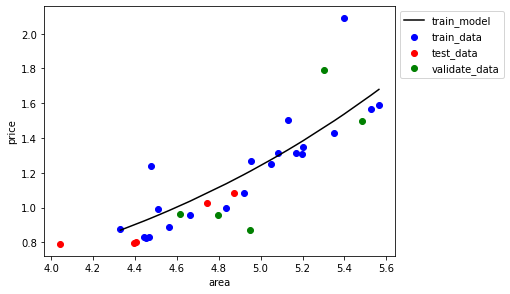

In [407]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [408]:
print("Polynomial Regression with degree = {}\n".format(degree))
# Polynomial Model coefficient and intercept:
print("Polynomial model coefficient:")
print(poly_model.coef_)
print("Polynomial model intercept: {}\n".format(poly_model.intercept_))

# poly_model rmse:
print("Polynomial Model RMSE on train data: {}".format(train_rmse))
print("Polynomial Model RMSE on validate data: {}".format(validate_rmse))
print("Polynomial Model RMSE on test data: {}".format(test_rmse))

Polynomial Regression with degree = 4

Polynomial model coefficient:
[0.         0.         0.         0.00264826 0.00093648]
Polynomial model intercept: [0.32546714]

Polynomial Model RMSE on train data: 0.1597700222376452
Polynomial Model RMSE on validate data: 0.23000021891309722
Polynomial Model RMSE on test data: 0.07983337883849148


In [409]:
# score the model with test data:

# Linear score:
print("\n")

linear_train_r2_score = linear_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = poly_model.score(X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)



Linear Model score on train dataset:  0.7362353063264007
Linear Model score on test dataset:  0.3241084841166416


Poly Model score on train dataset:  0.7400796182611491
Poly Model score on test dataset:  0.6117211627786644


In [410]:
# calc cross validation score of linear to compare with poly for best model selection
linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
best_model = linear_model if linear_cv > poly_cv else poly_model
best_degree = 1 if linear_cv > poly_cv else degree

print(linear_cv)
print(poly_cv)

-3.5424905960894413
-2.595271065975671


In [411]:
import unidecode
post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
street = unidecode.unidecode(street.lower().replace(" ", ""))
ward = unidecode.unidecode(ward.lower().replace(" ", ""))
district = unidecode.unidecode(district.lower().replace(" ", ""))
model_name = post_type + "_" + street + "_" + ward + "_" + district

In [412]:
# Save model after training for later use:
from joblib import dump, load

if best_r2_score > 0.7:
    # Save model:
    dump((best_model, best_degree), 'trained/' + model_name + ".joblib")

In [413]:
try:    
    # load model:
    loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

    test_area = np.array([92.00])
    test_area = test_area[:, np.newaxis]
    test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

    if loaded_degree == 1:
        predicted_price = loaded_model.predict(test_area)
    else:
        test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
        predicted_price = loaded_model.predict(test_area_poly)

    print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
except FileNotFoundError:
    print("Model not found or trained result is low!")

[0.90064162]
